<a href="https://colab.research.google.com/github/11sujan/sujan-ghorasaine-23246201-weatherwise/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [16]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus


In [ ]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

KeyboardInterrupt: Interrupted by user

## 📦 Setup and Configuration
Import required packages and setup environment.

In [45]:



import os
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyinputplus as pyip
from datetime import datetime, timedelta
import json
import re

# Optional: if your environment provides AI or external packages
try:
    from fetch_my_weather import get_weather
    WEATHER_AVAILABLE = True
except ImportError:
    WEATHER_AVAILABLE = False
    print("fetch-my-weather not available, will use wttr.in API")

# Matplotlib styling (works with or without seaborn installed)
if 'seaborn-v0_8' in plt.style.available:
    plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)


## 🌤️ Weather Data Functions

In [46]:
# 🌤️ Weather Data Functions
import requests
from urllib.parse import quote

def _safe(d, *keys, default=None):
    """Safe nested get for dict/list (avoids KeyError/IndexError)."""
    cur = d
    for k in keys:
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        elif isinstance(cur, list) and isinstance(k, int) and 0 <= k < len(cur):
            cur = cur[k]
        else:
            return default
    return cur

def get_weather_data(location, forecast_days=3):
    """
    Retrieve weather data for a specified location using wttr.in JSON (3-day forecast).

    Returns:
      dict:
        {
          "source": "wttr.in",
          "location": str,
          "current": dict,
          "forecast": list[dict],  # up to 3 entries
          "raw": dict
        }
      or on error:
        {"error": str, "location": original_location}
    """
    if not isinstance(location, str) or not location.strip():
        return {"error": "Location must be a non-empty string.", "location": location}

    try:
        days = max(1, min(int(forecast_days), 3))  # wttr.in provides 3 days
    except Exception:
        days = 3

    url = f"https://wttr.in/{quote(location.strip())}?format=j1"
    try:
        resp = requests.get(url, timeout=15)
        resp.raise_for_status()
        data = resp.json()
    except requests.exceptions.Timeout:
        return {"error": "Timeout contacting weather service", "location": location}
    except requests.exceptions.HTTPError as e:
        return {"error": f"HTTP error: {e}", "location": location}
    except Exception as e:
        return {"error": f"Error: {e}", "location": location}

    current = _safe(data, "current_condition", 0, default={}) or {}
    resolved_location = _safe(data, "nearest_area", 0, "areaName", 0, "value", default=location) or location
    forecast = _safe(data, "weather", default=[]) or []

    return {
    "source": "wttr.in",
    "requested_location": location.strip(),   # save the user's input
    "location": resolved_location,            # keep wttr.in's internal area
    "display_location": location.strip(),     # <-- this is what we’ll use for titles
    "current": current,
    "forecast": forecast[:days],
    "raw": data,
    }


## 📊 Visualisation Functions

In [69]:
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===== Helper functions =====
def _daily_series_from_wttrin(weather_data):
    """Extract daily values: dates, hiC, loC, avg_precip, avg_pop."""
    days = weather_data.get("forecast", [])
    dates, hiC, loC, avg_precip, avg_pop = [], [], [], [], []
    for d in days:
        dt = datetime.strptime(d["date"], "%Y-%m-%d")
        dates.append(dt)
        hi = d.get("maxtempC"); lo = d.get("mintempC")
        hiC.append(float(hi) if hi is not None else math.nan)
        loC.append(float(lo) if lo is not None else math.nan)

        hrs = d.get("hourly", []) or []
        if hrs:
            mm  = [float(h.get("precipMM", 0)) for h in hrs]
            pop = [float(h.get("chanceofrain", 0)) for h in hrs if h.get("chanceofrain") is not None]
            avg_precip.append(sum(mm)/len(mm) if mm else 0.0)
            avg_pop.append(sum(pop)/len(pop) if pop else math.nan)
        else:
            avg_precip.append(math.nan); avg_pop.append(math.nan)
    return dates, hiC, loC, avg_precip, avg_pop


def _title_loc_and_range(weather_data, dates):
    loc = weather_data.get("display_location", weather_data.get("requested_location", "Your city"))
    if dates:
        drange = f"{dates[0].strftime('%d %b')} – {dates[-1].strftime('%d %b')}"
        return f"{loc} · {drange}"
    return loc


# ===== Temperature =====
def create_temperature_visualisation(weather_data, output_type='display'):
    dates, hiC, loC, _, _ = _daily_series_from_wttrin(weather_data)
    if not dates:
        print("No forecast data to visualize.")
        return

    # Rolling mean of mid temps (3-pt window)
    mids = [(h+l)/2 for h, l in zip(hiC, loC)]
    roll = []
    for i in range(len(mids)):
        win = mids[max(0, i-1):min(len(mids), i+2)]
        vals = [v for v in win if not math.isnan(v)]
        roll.append(sum(vals)/len(vals) if vals else math.nan)

    fig, ax = plt.subplots()

    # Comfort band + weekend tick shading
    ax.axhspan(18, 26, alpha=0.12)
    for dt in dates:
        if dt.weekday() in (5, 6):
            ax.axvspan(dt, dt, alpha=0.08)

    # High/low + band + rolling mean
    ax.plot(dates, hiC, marker="o", markersize=7, linewidth=2, label="High")
    ax.plot(dates, loC, marker="o", markersize=7, linewidth=2, label="Low")
    ax.fill_between(dates, loC, hiC, alpha=0.25, linewidth=0)
    ax.plot(dates, roll, linestyle="--", linewidth=2, label="Rolling mean")

    # Annotate extrema
    valid_hi = [i for i, v in enumerate(hiC) if not math.isnan(v)]
    valid_lo = [i for i, v in enumerate(loC) if not math.isnan(v)]
    if valid_hi:
        i_max = max(valid_hi, key=lambda i: hiC[i])
        ax.annotate(f"Max {hiC[i_max]:.0f}°C", (dates[i_max], hiC[i_max]), xytext=(6, 10), textcoords="offset points")
    if valid_lo:
        i_min = min(valid_lo, key=lambda i: loC[i])
        ax.annotate(f"Min {loC[i_min]:.0f}°C", (dates[i_min], loC[i_min]), xytext=(6, -16), textcoords="offset points")

    ax.set_title(f"Temperatures — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("°C"); ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.grid(True, which="major", axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


# ===== Precipitation =====
def create_precipitation_visualisation(weather_data, output_type='display'):
    days = weather_data.get("forecast", [])
    if not days:
        print("No forecast data to visualize.")
        return

    dates, avg_precip, avg_pop = [], [], []
    for d in days:
        dt = datetime.strptime(d["date"], "%Y-%m-%d")
        hrs = d.get("hourly", []) or []
        mm  = [float(h.get("precipMM", 0)) for h in hrs]
        pop = [float(h.get("chanceofrain", 0)) for h in hrs if h.get("chanceofrain") is not None]
        dates.append(dt)
        avg_precip.append(sum(mm)/len(mm) if mm else 0.0)
        avg_pop.append(sum(pop)/len(pop) if pop else float("nan"))

    fig, ax = plt.subplots()
    ax.plot(dates, avg_precip, marker="o", markersize=6, linewidth=2, label="Avg precip (mm)")

    finite_pops = [p for p in avg_pop if isinstance(p, (int, float)) and math.isfinite(p)]
    has_pop = len(finite_pops) > 0

    if has_pop:
        max_precip = max(avg_precip) if avg_precip else 1.0
        max_pop = max(finite_pops) if finite_pops else 100.0
        target_peak_mm = max(max_precip, 1.0)
        scale = (target_peak_mm / max_pop) if max_pop > 0 else 0.01
        if not math.isfinite(scale) or scale <= 1e-9: scale = 0.01

        scaled_pop = [(p * scale) if math.isfinite(p) else float("nan") for p in avg_pop]
        ax.plot(dates, scaled_pop, marker="o", markersize=6, linewidth=2, label="Chance of rain (scaled)")

        # 50% line only (no emoji markers)
        thresh_y = 50.0 * scale
        ax.axhline(thresh_y, linestyle=":", linewidth=1)

        # Right axis for % values
        ax2 = ax.twinx()
        y0, y1 = ax.get_ylim()
        ax2.set_ylim(y0/scale, y1/scale)
        ax2.set_ylabel("% (right)")

    # Wettest-day tag
    if avg_precip:
        i_wet = max(range(len(avg_precip)), key=lambda i: avg_precip[i])
        ax.annotate(f"Wettest ~{avg_precip[i_wet]:.1f} mm", (dates[i_wet], avg_precip[i_wet]),
                    xytext=(6, 10), textcoords="offset points")

    ax.set_title(f"Precipitation & Rain Chance — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("mm (left)")
    ax.grid(True, which="major", axis="y", alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.legend(loc="upper right")
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


# ===== Humidity =====
def create_humidity_visualisation(weather_data, output_type='display'):
    days = weather_data.get("forecast", [])
    if not days:
        print("No forecast data to visualize.")
        return

    dates, avg_hum = [], []
    for d in days:
        try:
            dt = datetime.strptime(d["date"], "%Y-%m-%d")
        except Exception:
            continue
        hrs = d.get("hourly", []) or []
        hums = [float(h.get("humidity", 0)) for h in hrs if h.get("humidity") is not None]
        dates.append(dt)
        avg_hum.append(sum(hums)/len(hums) if hums else float("nan"))

    if not dates:
        print("No data to visualize.")
        return

    fig, ax = plt.subplots()
    ax.axhspan(30, 60, alpha=0.10)  # comfy humidity band
    for dt in dates:
        if dt.weekday() in (5, 6):
            ax.axvspan(dt, dt, alpha=0.08)

    ax.plot(dates, avg_hum, marker="o", linewidth=2)
    valid_idx = [i for i, h in enumerate(avg_hum) if math.isfinite(h)]
    if valid_idx:
        i_mug = max(valid_idx, key=lambda i: avg_hum[i])
        ax.annotate(f"Muggiest {avg_hum[i_mug]:.0f}%", (dates[i_mug], avg_hum[i_mug]),
                    xytext=(6, 10), textcoords="offset points")

    ax.set_title(f"Average Humidity — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("%")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.grid(True, which="major", axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


# ===== Wind =====
def create_wind_visualisation(weather_data, output_type='display'):
    days = weather_data.get("forecast", [])
    if not days:
        print("No forecast data to visualize.")
        return

    dates, max_wind = [], []
    for d in days:
        try:
            dt = datetime.strptime(d["date"], "%Y-%m-%d")
        except Exception:
            continue
        hrs = d.get("hourly", []) or []
        winds = [float(h.get("windspeedKmph", 0)) for h in hrs if h.get("windspeedKmph") is not None]
        dates.append(dt)
        max_wind.append(max(winds) if winds else float("nan"))

    if not dates:
        print("No data to visualize.")
        return

    fig, ax = plt.subplots()
    ax.axhspan(20, 30, alpha=0.08)
    ax.axhspan(30, 50, alpha=0.10)
    ax.axhspan(50, 200, alpha=0.12)
    for dt in dates:
        if dt.weekday() in (5, 6):
            ax.axvspan(dt, dt, alpha=0.08)

    ax.plot(dates, max_wind, marker="o", linewidth=2)
    valid_idx = [i for i, v in enumerate(max_wind) if math.isfinite(v)]
    if valid_idx:
        i_peak = max(valid_idx, key=lambda i: max_wind[i])
        ax.annotate(f"Peak {max_wind[i_peak]:.0f} km/h", (dates[i_peak], max_wind[i_peak]),
                    xytext=(6, 10), textcoords="offset points")

    ax.set_title(f"Max Wind Speed — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("km/h")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.grid(True, which="major", axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


## 🤖 Natural Language Processing

In [49]:
# 🤖 Natural Language Processing
import re
from datetime import datetime

_WEEKDAYS = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]

def parse_weather_question(question):
    """
    Parse user question for weather attributes and time.
    Returns: {"location", "time_period", "attribute"}
      - attribute ∈ {"rain","temperature","wind","humidity","general"}
      - time_period ∈ {"today","tomorrow","weekend"} or weekday, or "in_N_days"
    """
    q = (question or "").strip().lower()

    # location (in/for/at City Name...)
    m = re.search(r"\b(in|for|at)\s+([a-zA-Z][a-zA-Z\s\-\.',]+)$", q)
    location = m.group(2).strip().title() if m else "Perth"

    # attribute
    if any(w in q for w in ["rain","umbrella","precip"]):
        attribute = "rain"
    elif any(w in q for w in ["temperature","temp","hot","cold","warm","chilly"]):
        attribute = "temperature"
    elif "wind" in q:
        attribute = "wind"
    elif "humidity" in q:
        attribute = "humidity"
    else:
        attribute = "general"

    # time period
    time_period = "today"
    if "tomorrow" in q:
        time_period = "tomorrow"
    elif "weekend" in q:
        time_period = "weekend"
    else:
        for wd in _WEEKDAYS:
            if wd in q:
                time_period = wd
                break
        m2 = re.search(r"in\s+(\d+)\s+day", q)
        if m2:
            time_period = f"in_{m2.group(1)}_days"

    return {"location": location, "time_period": time_period, "attribute": attribute}

def _pick_day_from_forecast(forecast, time_period: str):
    """Map time_period to one of the 3 forecast days from wttr.in."""
    if not forecast:
        return {}
    if time_period == "tomorrow" and len(forecast) >= 2:
        return forecast[1]
    if time_period.startswith("in_") and time_period.endswith("_days"):
        try:
            n = int(time_period.split("_")[1])
            idx = max(0, min(n, len(forecast)-1))
            return forecast[idx]
        except Exception:
            return forecast[0]
    if time_period in _WEEKDAYS:
        for d in forecast:
            ds = d.get("date")
            try:
                if datetime.strptime(ds, "%Y-%m-%d").strftime("%A").lower() == time_period:
                    return d
            except Exception:
                pass
        return forecast[0]
    if time_period == "weekend":
        for d in forecast:
            ds = d.get("date")
            try:
                if datetime.strptime(ds, "%Y-%m-%d").weekday() in (5,6):
                    return d
            except Exception:
                pass
        return forecast[-1]
    return forecast[0]

def _avg_chance_of_rain(day_dict):
    hrs = day_dict.get("hourly", [])
    pops = []
    for h in hrs:
        try:
            pops.append(float(h.get("chanceofrain", 0)))
        except Exception:
            pass
    return (sum(pops)/len(pops)) if pops else None




## 🧭 User Interface

In [70]:
def main_menu():
    example_keywords = ['example questions', 'example', 'examples', 'show examples', 'sample', 'test', 'q', '3']
    print("="*40)
    print("🌤️ Welcome to WeatherWise!")
    print("Type your question, pick a menu number, or type 'example' anytime to see sample questions.")
    print("="*40)

    while True:
        raw_choice = pyip.inputStr(
            "\nMain Menu:\n"
            "- [1] Weather Forecast\n"
            "- [2] Ask Question\n"
            "- [3] Example Questions (type 'example')\n"
            "- [4] Exit\n"
            "Your choice: "
        ).strip().lower()

        if raw_choice in ('1', 'weather forecast', 'forecast'):
            location = pyip.inputStr("Enter city or location: ")
            if not location.strip():
                print("Please enter a city name.")
                continue
            data = get_weather_data(location)
            if isinstance(data, dict) and "error" in data:
                print(f"[Error] {data['error']}")
                continue
            print(f"\nForecast for {data.get('location', location)}:")
            create_temperature_visualisation(data)
            create_precipitation_visualisation(data)
            create_wind_visualisation(data)
            create_humidity_visualisation(data)

        elif raw_choice in ('2', 'ask question', 'ask', 'question'):
            q = pyip.inputStr("Type your weather question: ")
            if not q.strip():
                print("Please ask a question or choose an option.")
                continue
            pq = parse_weather_question(q)
            ask_loc = pq.get("location")
            data = get_weather_data(ask_loc)
            if isinstance(data, dict) and "error" in data:
                print(f"[Error] {data['error']}")
                continue
            print("\nHere's what I found:")
            print(generate_weather_response(pq, data))

        elif raw_choice in example_keywords:
            print("\nSome things you can ask:")
            print("- Will it rain in Darwin this weekend?")
            print("- Show me the temperature for Perth tomorrow.")
            print("- What's the forecast in Brisbane today?")
            print("- Is it windy in Melbourne right now?")
            print("- Will I need an umbrella in Hobart on Friday?")

        elif raw_choice in ('4', 'exit', 'quit', 'bye'):
            print("\nThank you for using WeatherWise. Stay safe!")
            break

        else:
            print("Not a valid option. Type 'example' to see what you can ask, or choose 1, 2, 3, or 4.")


## 🧩 Main Application Logic

🌤️ Welcome to WeatherWise!
Type your question, pick a menu number, or type 'example' anytime to see sample questions.

Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Example Questions (type 'example')
- [4] Exit
Your choice: 1
Enter city or location: perth

Forecast for Maylands:


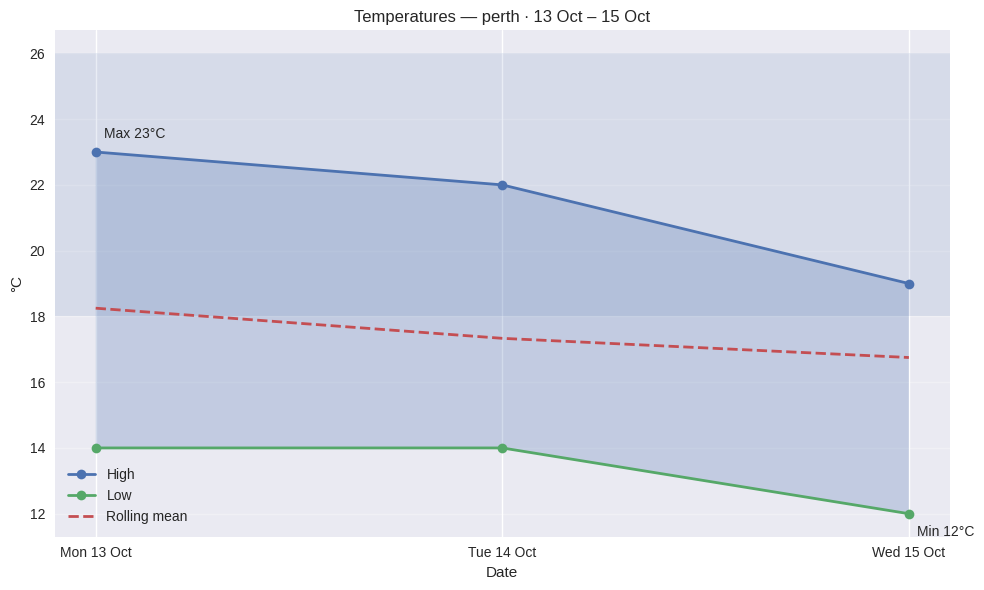

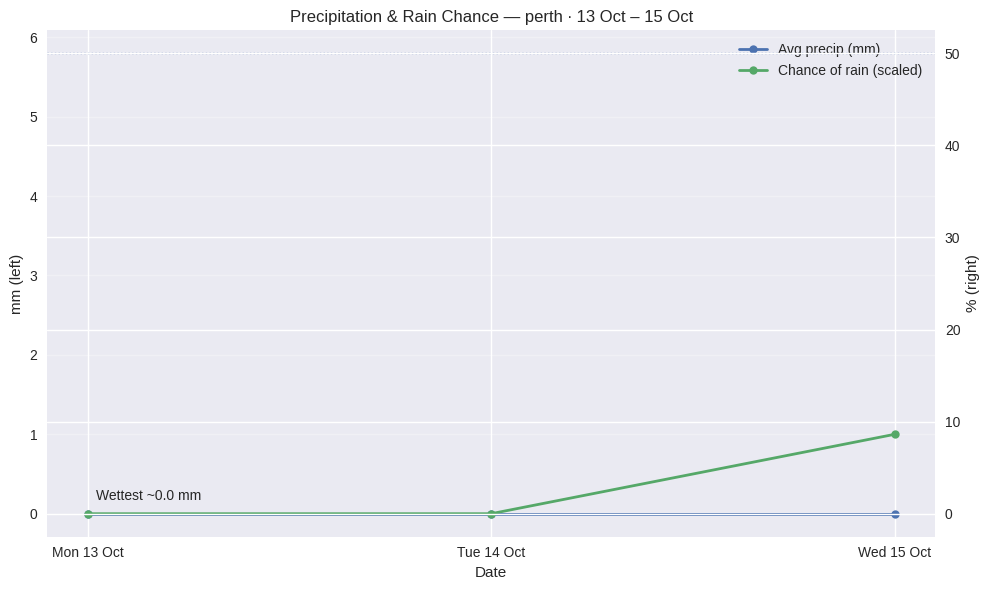

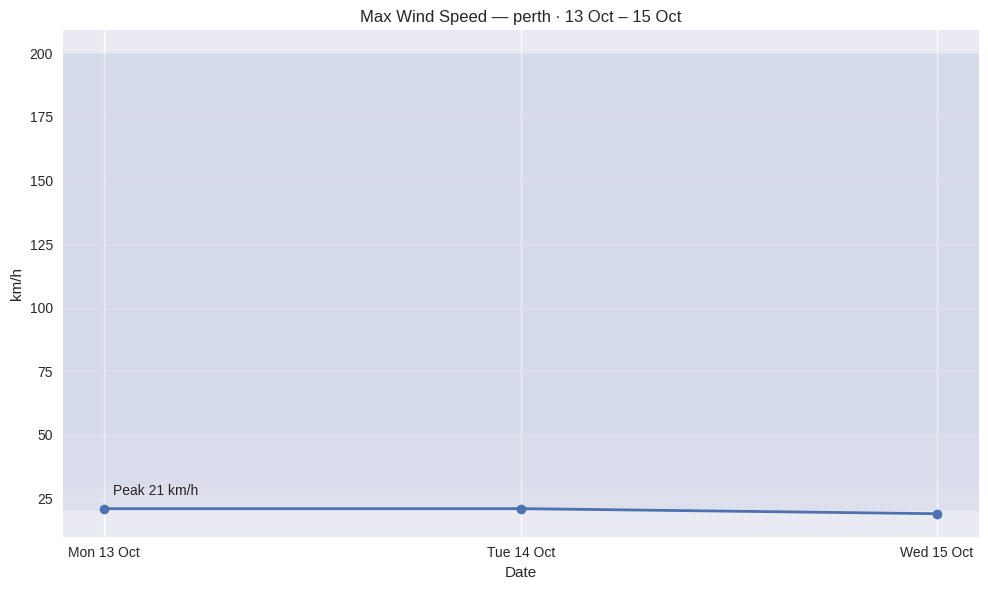

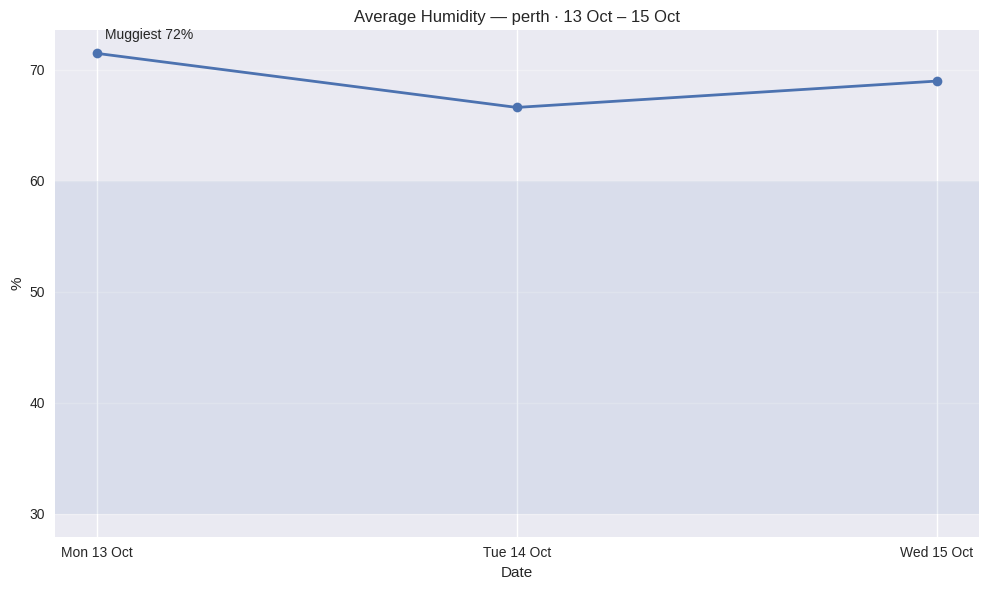


Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Example Questions (type 'example')
- [4] Exit
Your choice: 4

Thank you for using WeatherWise. Stay safe!


In [71]:
# Tie everything together here


if __name__ == "__main__":
    main_menu()

## 🧪 Testing and Examples

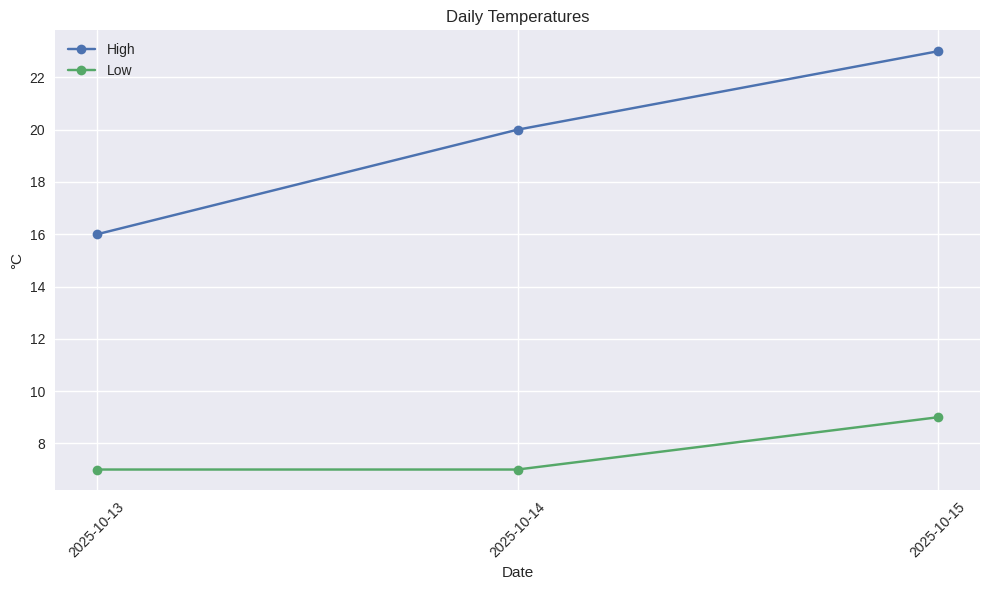

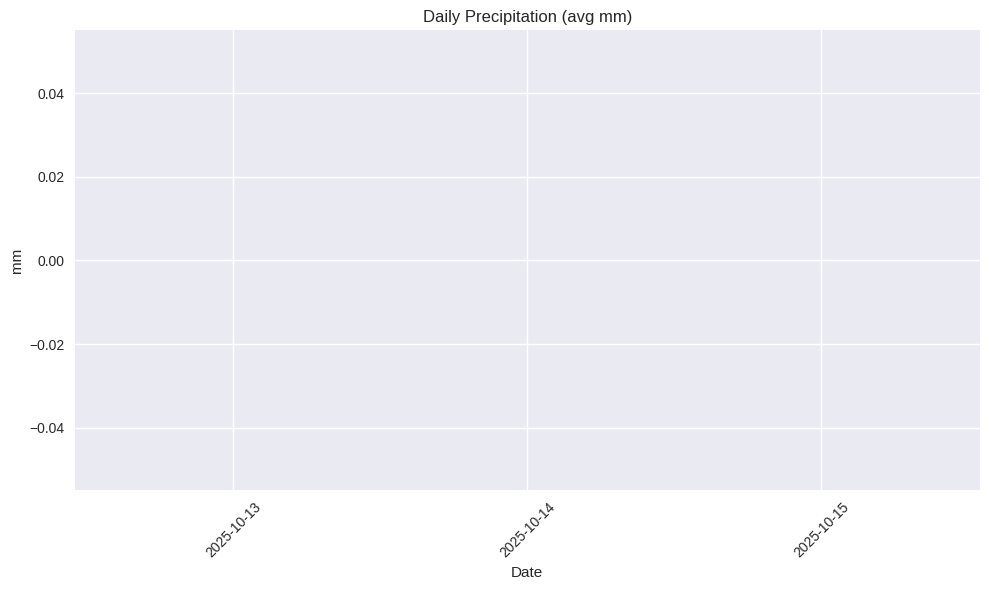

Unlikely—only about 0% chance of rain in Perth. Expect high 22°C / low 14°C; Clear .


In [9]:
# Include sample input/output for each function

# Sample test
# Quick smoke test
sample = get_weather_data('Melbourne')
if isinstance(sample, dict) and "error" not in sample:
    create_temperature_visualisation(sample)
    create_precipitation_visualisation(sample)
    pq = parse_weather_question("Will it rain tomorrow in Paris?")
    pdata = get_weather_data(pq['location'])
    print(generate_weather_response(pq, pdata))
else:
    print("Fetch error:", sample)



## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.